下載 & 解壓 IMDb 資料

In [9]:
import urllib.request
import gzip
import shutil
import os
import time

def download_and_extract(url, output_filename, max_retries=3):
    gz_path = output_filename + '.gz'
    
    for attempt in range(max_retries):
        try:
            print(f"Downloading (attempt {attempt + 1})...")
            urllib.request.urlretrieve(url, gz_path)
            print(f"Downloaded: {gz_path}")
            
            with gzip.open(gz_path, 'rb') as f_in:
                with open(output_filename, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"Extracted: {output_filename}")
            break  # 成功就跳出 retry loop

        except Exception as e:
            print(f"Error: {e}")
            if attempt == max_retries - 1:
                raise  # 最後一次失敗就報錯
            else:
                print("Retrying after 5 seconds...")
                time.sleep(5)
                if os.path.exists(gz_path):
                    os.remove(gz_path)  # 刪除殘留的不完整檔案


In [10]:
download_and_extract("https://datasets.imdbws.com/title.basics.tsv.gz", "title.basics.tsv")
download_and_extract("https://datasets.imdbws.com/title.principals.tsv.gz", "title.principals.tsv")
download_and_extract("https://datasets.imdbws.com/name.basics.tsv.gz", "name.basics.tsv")


Downloaded: title.basics.tsv.gz
Extracted: title.basics.tsv
Downloaded: title.principals.tsv.gz
Extracted: title.principals.tsv
Downloaded: name.basics.tsv.gz
Extracted: name.basics.tsv


In [3]:

# !wget https://datasets.imdbws.com/title.basics.tsv.gz
# !wget https://datasets.imdbws.com/title.principals.tsv.gz
# !wget https://datasets.imdbws.com/name.basics.tsv.gz

# !gunzip title.basics.tsv.gz
# !gunzip title.principals.tsv.gz
# !gunzip name.basics.tsv.gz

!wget -N https://datasets.imdbws.com/title.basics.tsv.gz
!wget -N https://datasets.imdbws.com/title.principals.tsv.gz
!wget -N https://datasets.imdbws.com/name.basics.tsv.gz

!gunzip -f title.basics.tsv.gz
!gunzip -f title.principals.tsv.gz
!gunzip -f name.basics.tsv.gz


--2025-05-21 22:30:45--  https://datasets.imdbws.com/title.basics.tsv.gz
正在查找主機 datasets.imdbws.com (datasets.imdbws.com)... 3.169.121.100, 3.169.121.125, 3.169.121.105, ...
正在連接 datasets.imdbws.com (datasets.imdbws.com)|3.169.121.100|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 304 Not Modified
檔案 「title.basics.tsv.gz」 未在伺服器上變更。忽略此下載任務。

--2025-05-21 22:30:47--  https://datasets.imdbws.com/title.principals.tsv.gz
正在查找主機 datasets.imdbws.com (datasets.imdbws.com)... 3.169.121.100, 3.169.121.125, 3.169.121.105, ...
正在連接 datasets.imdbws.com (datasets.imdbws.com)|3.169.121.100|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 304 Not Modified
檔案 「title.principals.tsv.gz」 未在伺服器上變更。忽略此下載任務。

--2025-05-21 22:30:47--  https://datasets.imdbws.com/name.basics.tsv.gz
正在查找主機 datasets.imdbws.com (datasets.imdbws.com)... 3.169.121.100, 3.169.121.125, 3.169.121.105, ...
正在連接 datasets.imdbws.com (datasets.imdbws.com)|3.169.121.100|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 304 Not Modified
檔案 「name.basics.tsv.gz」 未在伺服器上變更。忽略此下載任務。



PostgreSQL 資料表

In [4]:
!pip install psycopg2

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for psycopg2: filename=psycopg2-2.9.10-cp312-cp312-macosx_11_0_arm64.whl size=133479 sha256=fff9d61bc22396dcf5a06dc054aafcbe13e1d934db219e10a00663248ec948d7
  Stored in directory: /Users/magielin/Library/Caches/pip/wheels/ac/bb/ce/afa589c50b6004d3a06fc691e71bd09c9bd5f01e5921e5329b
Successfully built psycopg2

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [20]:
import psycopg2

# 連接資料庫
conn = psycopg2.connect(
    dbname="autosteer_db",
    user="autosteer",
    password="autosteer_database", 
    host="localhost",
    port="5432"
)
cur = conn.cursor()

# 建立資料表
cur.execute("""
    CREATE TABLE IF NOT EXISTS title_basics (
        tconst TEXT PRIMARY KEY,
        titleType TEXT,
        primaryTitle TEXT,
        originalTitle TEXT,
        isAdult BOOLEAN,
        startYear INTEGER,
        endYear INTEGER,
        runtimeMinutes INTEGER,
        genres TEXT
    );
""")

cur.execute("""
    CREATE TABLE IF NOT EXISTS title_principals (
        tconst TEXT,
        ordering INTEGER,
        nconst TEXT,
        category TEXT,
        job TEXT,
        characters TEXT
    );
""")

cur.execute("""
    CREATE TABLE IF NOT EXISTS name_basics (
        nconst TEXT PRIMARY KEY,
        primaryName TEXT,
        birthYear INTEGER,
        deathYear INTEGER,
        primaryProfession TEXT,
        knownForTitles TEXT
    );
""")

# 提交並關閉
conn.commit()
cur.close()
conn.close()

print("✅ Tables created successfully.")


✅ Tables created successfully.


IMDb 資料匯入

In [25]:
import psycopg2
import time
import random

# PostgreSQL 連線資訊
# conn_info = {
#     'dbname': 'imdb',
#     'user': 'postgres',
#     'password': 'autosteer_database',
#     'host': 'localhost',
#     'port': 5432
# }


# 固定查詢語句（你可以改成你自己的）
# QUERY = """
# SELECT t."primaryTitle", t."startYear"
# FROM title_principals p
# JOIN name_basics n ON p.nconst = n.nconst
# JOIN title_basics t ON p.tconst = t.tconst
# WHERE n."primaryName" = 'Tom Hanks';
# """

QUERY = """
SELECT t.primarytitle, t.startyear
FROM title_principals p
JOIN name_basics n ON p.nconst = n.nconst
JOIN title_basics t ON p.tconst = t.tconst
WHERE n.primaryname = 'Tom Hanks';
"""


# 根據 Hint 建立或刪除索引
# def apply_hint_indexes(hint):
    
#     conn = psycopg2.connect(
#         dbname="autosteer_db",
#         user="autosteer",
#         password="autosteer_database", 
#         host="localhost",
#         port="5432"
#     )
#     cur = conn.cursor()

#     if hint == 'A':
#         # Hint-A：針對查詢重點欄位加索引
#         cur.execute('CREATE INDEX IF NOT EXISTS idx_name_primaryName ON name_basics("primaryName");')
#         cur.execute("CREATE INDEX IF NOT EXISTS idx_principal_nconst ON title_principals(nconst);")
#         cur.execute('CREATE INDEX IF NOT EXISTS idx_title_primaryTitle ON title_basics("primaryTitle");')

#     elif hint == 'B':
#         # Hint-B：加在與查詢不太相關的欄位上（模擬 suboptimal hints）
#         cur.execute('CREATE INDEX IF NOT EXISTS idx_title_startYear ON title_basics("startYear");')
#         cur.execute('CREATE INDEX IF NOT EXISTS idx_title_type ON title_basics("titleType");')

#     elif hint == 'C':
#         # Hint-C：模擬沒有提示，全部刪除（靠 PostgreSQL 自行選計劃）
#         cur.execute("DROP INDEX IF EXISTS idx_name_primaryName;")
#         cur.execute("DROP INDEX IF EXISTS idx_principal_nconst;")
#         cur.execute("DROP INDEX IF EXISTS idx_title_startYear;")
#         cur.execute("DROP INDEX IF EXISTS idx_title_type;")
#         cur.execute("DROP INDEX IF EXISTS idx_title_primaryTitle;")
        
#     print(f"→ Applying Hint {hint}")


#     conn.commit()
#     conn.close()

def apply_hint_indexes(hint):
    conn = psycopg2.connect(
        dbname="autosteer_db",
        user="autosteer",
        password="autosteer_database", 
        host="localhost",
        port="5432"
    )
    cur = conn.cursor()

    if hint == 'A':
        # Hint-A：針對查詢重點欄位加索引
        cur.execute('CREATE INDEX IF NOT EXISTS idx_name_primaryname ON name_basics(primaryname);')
        cur.execute('CREATE INDEX IF NOT EXISTS idx_principal_nconst ON title_principals(nconst);')
        cur.execute('CREATE INDEX IF NOT EXISTS idx_title_primarytitle ON title_basics(primarytitle);')

    elif hint == 'B':
        # Hint-B：加在與查詢不太相關的欄位上（模擬 suboptimal hints）
        cur.execute('CREATE INDEX IF NOT EXISTS idx_title_startyear ON title_basics(startyear);')
        cur.execute('CREATE INDEX IF NOT EXISTS idx_title_type ON title_basics(titletype);')

    elif hint == 'C':
        # Hint-C：模擬沒有提示，全部刪除（靠 PostgreSQL 自行選計劃）
        cur.execute('DROP INDEX IF EXISTS idx_name_primaryname;')
        cur.execute('DROP INDEX IF EXISTS idx_principal_nconst;')
        cur.execute('DROP INDEX IF EXISTS idx_title_startyear;')
        cur.execute('DROP INDEX IF EXISTS idx_title_type;')
        cur.execute('DROP INDEX IF EXISTS idx_title_primarytitle;')

    print(f"→ Applying Hint {hint}")
    conn.commit()
    conn.close()


In [26]:
# 執行查詢並回傳 latency（毫秒）
def run_query():
    conn = psycopg2.connect(
        dbname="autosteer_db",
        user="autosteer",
        password="autosteer_database", 
        host="localhost",
        port="5432"
    )
    cur = conn.cursor()
    start = time.time()
    cur.execute(QUERY)
    cur.fetchall()
    end = time.time()
    conn.close()
    return (end - start) * 1000  # ms

# 儲存每組 Hint 的 latency 記錄
history = {'A': [], 'B': [], 'C': []}

# 執行 N 輪測試
for i in range(30):
    hint = random.choice(['A', 'B', 'C'])  # 隨機選 Hint-set
    apply_hint_indexes(hint)              # 套用對應索引策略
    latency = run_query()                 # 執行查詢 + 計時
    history[hint].append(latency)
    print(f"Round {i+1:02d}: Hint={hint}, Latency={latency:.2f} ms")

# 顯示平均結果
print("\n📊 [AutoSteer++] Average Latency per Hint:")
for hint, times in history.items():
    avg = sum(times) / len(times) if times else 0
    print(f"Hint {hint}: {avg:.2f} ms over {len(times)} runs")

→ Applying Hint B
Round 01: Hint=B, Latency=1.88 ms
→ Applying Hint A
Round 02: Hint=A, Latency=1.38 ms
→ Applying Hint C
Round 03: Hint=C, Latency=0.93 ms
→ Applying Hint C
Round 04: Hint=C, Latency=0.81 ms
→ Applying Hint C
Round 05: Hint=C, Latency=0.73 ms
→ Applying Hint C
Round 06: Hint=C, Latency=0.74 ms
→ Applying Hint A
Round 07: Hint=A, Latency=0.93 ms
→ Applying Hint C
Round 08: Hint=C, Latency=0.82 ms
→ Applying Hint B
Round 09: Hint=B, Latency=0.92 ms
→ Applying Hint C
Round 10: Hint=C, Latency=0.73 ms
→ Applying Hint B
Round 11: Hint=B, Latency=0.76 ms
→ Applying Hint A
Round 12: Hint=A, Latency=0.87 ms
→ Applying Hint A
Round 13: Hint=A, Latency=0.84 ms
→ Applying Hint B
Round 14: Hint=B, Latency=0.82 ms
→ Applying Hint A
Round 15: Hint=A, Latency=0.84 ms
→ Applying Hint B
Round 16: Hint=B, Latency=0.83 ms
→ Applying Hint C
Round 17: Hint=C, Latency=0.69 ms
→ Applying Hint C
Round 18: Hint=C, Latency=0.69 ms
→ Applying Hint C
Round 19: Hint=C, Latency=0.69 ms
→ Applying H

In [27]:
# # 執行 N 輪測試
# for i in range(30):
#     hint = random.choice(['A', 'B', 'C'])  # 隨機選 Hint-set
#     apply_hint_indexes(hint)              # 套用對應索引策略
#     latency = run_query()                 # 執行查詢 + 計時
#     history[hint].append(latency)
#     print(f"Round {i+1:02d}: Hint={hint}, Latency={latency:.2f} ms")

# # 顯示平均結果
# print("\n📊 [AutoSteer++] Average Latency per Hint:")
# for hint, times in history.items():
#     avg = sum(times) / len(times) if times else 0
#     print(f"Hint {hint}: {avg:.2f} ms over {len(times)} runs")

# ----------------------------
# 🟠 Baseline (No Learning, fixed Hint)
# ----------------------------
baseline_hint = ['A', 'B', 'C']  # 固定使用某組 hint（模擬選錯情況）
history = {'A': [], 'B': [], 'C': []}

for hint in baseline_hint:
    for i in range(30):
        apply_hint_indexes(hint)              # 套用對應索引策略
        latency = run_query()                 # 執行查詢 + 計時
        history[hint].append(latency)
        print(f"[Baseline]     Round {i+1:02d}: Hint={hint}, Latency={latency:.2f} ms")
        # print(f"[Baseline]     Round {i+1}: Hint={hint}, Latency={latency:.2f} ms")

# 顯示平均結果
print("\n📊 [Baseline] Average Latency per Hint:")
for hint, times in history.items():
    avg = sum(times) / len(times) if times else 0
    print(f"Hint {hint}: {avg:.2f} ms over {len(times)} runs")

→ Applying Hint A
[Baseline]     Round 01: Hint=A, Latency=1.76 ms
→ Applying Hint A
[Baseline]     Round 02: Hint=A, Latency=1.40 ms
→ Applying Hint A
[Baseline]     Round 03: Hint=A, Latency=1.42 ms
→ Applying Hint A
[Baseline]     Round 04: Hint=A, Latency=1.10 ms
→ Applying Hint A
[Baseline]     Round 05: Hint=A, Latency=1.11 ms
→ Applying Hint A
[Baseline]     Round 06: Hint=A, Latency=1.11 ms
→ Applying Hint A
[Baseline]     Round 07: Hint=A, Latency=1.13 ms
→ Applying Hint A
[Baseline]     Round 08: Hint=A, Latency=3.01 ms
→ Applying Hint A
[Baseline]     Round 09: Hint=A, Latency=4.97 ms
→ Applying Hint A
[Baseline]     Round 10: Hint=A, Latency=1.06 ms
→ Applying Hint A
[Baseline]     Round 11: Hint=A, Latency=1.01 ms
→ Applying Hint A
[Baseline]     Round 12: Hint=A, Latency=0.92 ms
→ Applying Hint A
[Baseline]     Round 13: Hint=A, Latency=0.96 ms
→ Applying Hint A
[Baseline]     Round 14: Hint=A, Latency=0.93 ms
→ Applying Hint A
[Baseline]     Round 15: Hint=A, Latency=0.9

→ Applying Hint A
[AutoSteer++] Round 01: Hint=A, Latency=1.50 ms
→ Applying Hint A
[AutoSteer++] Round 02: Hint=A, Latency=1.88 ms
→ Applying Hint A
[AutoSteer++] Round 03: Hint=A, Latency=1.07 ms
→ Applying Hint A
[AutoSteer++] Round 04: Hint=A, Latency=7.24 ms
→ Applying Hint A
[AutoSteer++] Round 05: Hint=A, Latency=0.98 ms
→ Applying Hint A
[AutoSteer++] Round 06: Hint=A, Latency=1.02 ms
→ Applying Hint A
[AutoSteer++] Round 07: Hint=A, Latency=1.00 ms
→ Applying Hint A
[AutoSteer++] Round 08: Hint=A, Latency=0.97 ms
→ Applying Hint A
[AutoSteer++] Round 09: Hint=A, Latency=1.06 ms
→ Applying Hint A
[AutoSteer++] Round 10: Hint=A, Latency=0.97 ms
→ Applying Hint A
[AutoSteer++] Round 11: Hint=A, Latency=0.89 ms
→ Applying Hint A
[AutoSteer++] Round 12: Hint=A, Latency=0.94 ms
→ Applying Hint A
[AutoSteer++] Round 13: Hint=A, Latency=0.85 ms
→ Applying Hint A
[AutoSteer++] Round 14: Hint=A, Latency=0.90 ms
→ Applying Hint A
[AutoSteer++] Round 15: Hint=A, Latency=0.90 ms
→ Applying

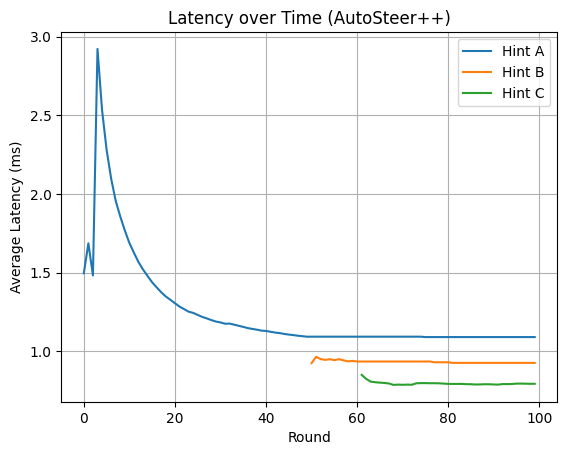

→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying Hint A
→ Applying

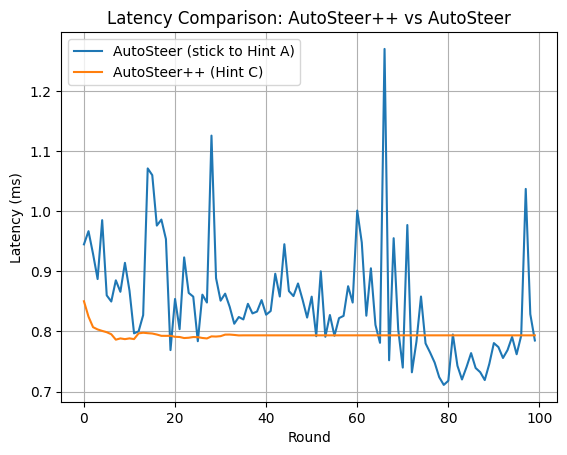

In [ ]:
import matplotlib.pyplot as plt

epsilon = 0.1  # 探索機率
rounds = 100
history = {'A': [], 'B': [], 'C': []}
latency_record = {'A': [], 'B': [], 'C': []}  # 用來畫圖

for i in range(rounds):
    if random.random() < epsilon:
        hint = random.choice(['A', 'B', 'C'])  # explore
    else:
        # exploit: choose the best (lowest avg latency)
        hint = min(history, key=lambda h: sum(history[h])/len(history[h]) if history[h] else float('inf'))

    apply_hint_indexes(hint)
    latency = run_query()
    history[hint].append(latency)

    # 累積 latency 曲線資料
    for h in ['A', 'B', 'C']:
        avg = sum(history[h]) / len(history[h]) if history[h] else None
        latency_record[h].append(avg)

    print(f"[AutoSteer++] Round {i+1:02d}: Hint={hint}, Latency={latency:.2f} ms")

# 📈 畫圖比較三組 hint latency 曲線
for h in ['A', 'B', 'C']:
    plt.plot(latency_record[h], label=f'Hint {h}')
plt.title("Latency over Time (AutoSteer++)")
plt.xlabel("Round")
plt.ylabel("Average Latency (ms)")
plt.legend()
plt.grid(True)
plt.show()


######################################
# baseline 模擬：固定用 Hint A 來查詢
baseline_history = []
for i in range(rounds):
    apply_hint_indexes('A')  # 永遠選 Hint A（模擬 AutoSteer）
    latency = run_query()
    baseline_history.append(latency)

print(f"AutoSteer++ 平均 latency: {sum([lat for h in history for lat in history[h]]) / rounds:.2f} ms")
print(f"AutoSteer baseline 平均 latency: {sum(baseline_history) / rounds:.2f} ms")

plt.plot(baseline_history, label="AutoSteer (stick to Hint A)")
plt.plot([sum(history['C'][:i+1])/len(history['C'][:i+1]) if history['C'][:i+1] else None for i in range(rounds)], label="AutoSteer++ (Hint C)")
plt.title("Latency Comparison: AutoSteer++ vs AutoSteer")
plt.xlabel("Round")
plt.ylabel("Latency (ms)")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
# Linux / macOS / Git Bash
# chmod +x import_all.sh
# ./import_all.sh

In [ ]:
# Windows PowerShell
# ./import_all.ps1